# Intro

*This example shows how estimators and outlier detectors can be conveniently combined with
[__scikit-fallback__](https://github.com/sanjaradylov/scikit-fallback).*

`skfb.estimators.AnomalyFallbackClassifier` is one of scikit-fallback's rejectors added in v0.1.0.
It accepts both an outlier detector and a classifier using the former as a rejection rule.

Here, we combine [`sklearn.svm.OneClassSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#oneclasssvm)
and [`sklearn.neural_network.MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#mlpclassifier)
to classify our custom version of MNIST digits that can also be noisy and ambiguous.

First, import all the necessary objects.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from skfb.estimators import AnomalyFallbackClassifier
from skfb.metrics import PAConfusionMatrixDisplay

from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM

# MNIST with outliers.

Next, download the original MNIST 28x28 dataset.

In [2]:
X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="liac-arff")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)
X_train.shape, X_test.shape

((56000, 784), (14000, 784))

Now, augment the data w/ random images; they'll be labeled as fallbacks (we set `fallback_label="@"`)
and evaluated w/ combined metrics from scikit-fallback.

In [3]:
def generate_random_mnist(X):
    """Generates random combination of two images from different classes."""
    p = np.random.rand()
    first = X[np.random.choice(X.shape[0])].reshape(28, 28)
    second = X[np.random.choice(X.shape[0])].reshape(28, 28)

    # region One image overrides the other
    if p <= 0.2:
        alpha_first = np.random.uniform(0.5, 1.0)
        alpha_second = np.random.uniform(0.5, 1.0)
        outlier = alpha_first * first + alpha_second * second
    # endregion

    # region Two images are merged
    else:
        d = np.random.randint(11, 17)
        outlier = np.concat([first[:, d:], second[:, 28 - d:]], axis=1)
    # endregion

    # region Add noise
    add_noise = np.random.rand() <= 0.25
    if add_noise:
        outlier = np.random.randint(0, 256, size=outlier.shape) + outlier
        outlier = np.clip(outlier, 0, 256)
    # endregion

    return outlier.reshape(28 * 28)

fallback_label = "@"
X_random = np.array([generate_random_mnist(X_test) for _ in range(len(X_test))])
X_comb = np.concatenate([X_test, X_random])
y_random = np.array([fallback_label] * len(X_random))
y_comb = np.concatenate([y_test, y_random])
X_comb.shape, y_comb.shape

((28000, 784), (28000,))

# Outlier Detection

We will use `OneClassSVM` as an outlier detector (feel free to test any other model).

In [4]:
outlier_detector = make_pipeline(MinMaxScaler(), OneClassSVM(nu=0.03))
outlier_detector.fit(X_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('oneclasssvm', OneClassSVM(nu=0.03))])

Here we predict whether a sample from the augmented data is an inlier.

In [5]:
y_pred = outlier_detector.predict(X_comb)
y_inout = y_comb.copy()
y_inout[y_inout != fallback_label] = 1
y_inout[y_inout == fallback_label] = -1
y_inout = y_inout.astype(int)

Having `y_inout` as true inlier-outlier labels and `y_pred` as SVM predictions,
we calculate *balanced accuracy* - an average of inlier and outlier
recalls:

$$
\text{balanced-accuracy}(y, \hat{y}) = \frac{1}{2}\frac{TI}{TI + FO} + \frac{1}{2}\frac{TO}{TO + FI}
$$

Balanced inlier-outlier accuracy: 94.45%


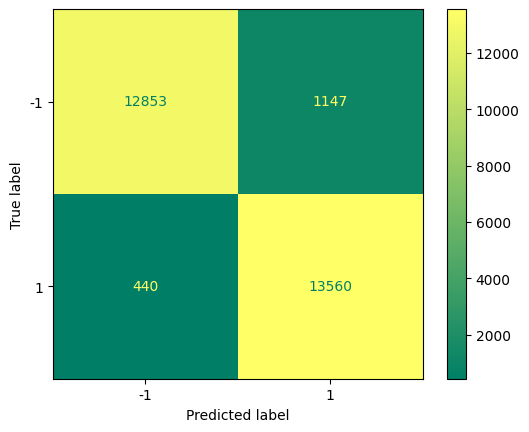

In [6]:
print(
    f"Balanced inlier-outlier accuracy: "
    f"{balanced_accuracy_score(y_pred, y_inout) * 100.:.2f}%"
)
ConfusionMatrixDisplay.from_predictions(y_inout, y_pred, cmap="summer")
plt.show()

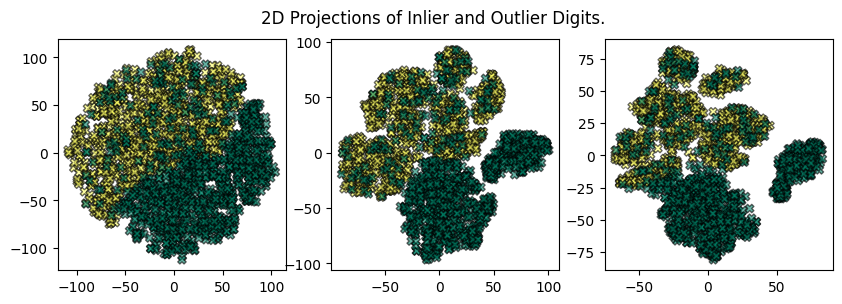

In [7]:
y_sample = np.concat([y_inout[:1_000], y_inout[-1_000:]])

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, p in enumerate((5, 30, 70)):
    X_t = TSNE(perplexity=p, random_state=0).fit_transform(X_comb)
    X_sample = np.concatenate([X_t[:1_000], X_t[14_000:15_000]])
    axes[i].scatter(
        X_sample[:, 0], X_sample[:, 1],
        c=y_sample, alpha=0.6, edgecolor="k", cmap="summer", marker="X"
    )
fig.suptitle("2D Projections of Inlier and Outlier Digits.")
plt.show()

The inlier-outlier confusion matrix as well as the balanced accuracy shows how in overall
`OneClassSVC` can discriminate between genuine and ambiguous digits w/ a slight preference
for falsely accepting outliers. Having this observation and knowing that sometimes inputs
can be noisy (e.g., images of extremely low quality) or ambiguous (e.g., two numbers in a
card) as presented in our custom dataset, we might want to incorporate this outlier detector
into our classification pipeline.

# Combined Prediction and Evaluation

Let's do this by combining the outlier detector `OneClassSVM` and a classifier `MLPClassifier` w/
scikit-fallback's `AnomalyFallbackClassifier`.

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
estimator = MLPClassifier(
    hidden_layer_sizes=(40,),
    max_iter=20,
    alpha=1e-2,
    solver="adam",
    random_state=0,
    learning_rate_init=0.005,
    early_stopping=True,
    validation_fraction=0.11,
    n_iter_no_change=5,
    tol=1e-3,
)
outlier_detector = OneClassSVM(nu=0.03)
rejector = AnomalyFallbackClassifier(
    estimator,
    outlier_detector,
    fallback_mode="return",
    fallback_label=fallback_label,
)
pipe = Pipeline([("scale", scaler), ("reject", rejector)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('reject',
                 AnomalyFallbackClassifier(estimator=MLPClassifier(alpha=0.01,
                                                                   early_stopping=True,
                                                                   hidden_layer_sizes=(40,),
                                                                   learning_rate_init=0.005,
                                                                   max_iter=20,
                                                                   n_iter_no_change=5,
                                                                   random_state=0,
                                                                   tol=0.001,
                                                                   validation_fraction=0.11),
                                           fallback_label='@',
                                           fallback_mode='return',
                                           outlier_detector=OneClassSVM(nu=0.03)))])

How does the classifier perform on accepted samples compared to the whole dataset?

We can set `fallback_mode` to:
* `"ignore"` and calculate accuracy score w/o fallbacks;
* `"return"` and return fallbacks (labeled w/ `"@"`) along w/ classes and calculate
  accuracy score on accepted predictions;
* or `"store"` (see the next cell).

According to our configuration of an outlier rejector, up to 3% of data is expected to
be outliers.

In [11]:
pipe.set_params(reject__fallback_mode="ignore")
print("MLPClassifier without fallbacks:")
print(f"Train accuracy: {pipe.score(X_train, y_train) * 100.0:.2f}%")
print(f"Test  accuracy: {pipe.score(X_test, y_test) * 100.0:.2f}%")

pipe.set_params(reject__fallback_mode="return")
print("\nMLPClassifier with fallbacks:")
print(f"Train accuracy: {pipe.score(X_train, y_train) * 100.0:.2f}%")
print(f"Test  accuracy: {pipe.score(X_test, y_test) * 100.0:.2f}%")

MLPClassifier without fallbacks:
Train accuracy: 98.59%
Test  accuracy: 96.71%

MLPClassifier with fallbacks:
Train accuracy: 98.60%
Test  accuracy: 96.75%


Fortunately, we have an increase in accuracy albeit a small one...

But now, let's calculate *prediction-rejection accuracy score*:
$$
\text{predict-reject-accuracy}(y, \hat{y}) = \frac{TA + TR}{TA + TR + FA + FR}
$$
where A and R stand for acceptance and rejection, respectively; here, *True Acceptance* means
not rejecting true prediction, and *True Rejection* means rejecting false prediction.

Setting `fallback_mode="store"` will return an `FBNDArray` of class predictions w/ fallback
mask; the `score` method will calculate the metric above.

Predict-reject accuracy score: 92.96%


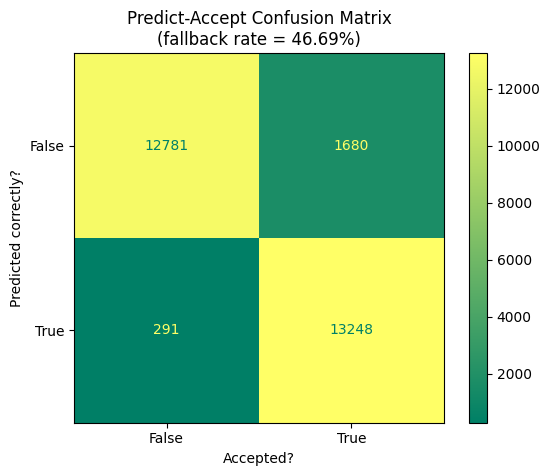

In [10]:
pipe.set_params(reject__fallback_mode="store")
print(f"Predict-reject accuracy score: {pipe.score(X_comb, y_comb) * 100.0:.2f}%")

PAConfusionMatrixDisplay.from_estimator(pipe, X_comb, y_comb, cmap="summer")
plt.show()

As we can see, almost half of the predictions were rejected with 88.3% of them being recalled.

# Conclusion

That's all folks! 🙂

Overall, we have a scikit-learn compatible models and scorers to combine
classifier and anomaly detector predictions to create and evaluate predictive
models w/ rejections. `skfb.estimators.AnomalyFallbackClassifier` accepts an
outlier detector and a classifier to decide whether to reject or classify objects,
respectively.

Along w/ the introduced features, `AnomalyFallbackClassifier` also supports inference
w/ already fitted `outlier_detector` and `estimator`, and training the estimator on
the data filtered by the outlier detector.

And of course, stay tuned for more updates ✨